## Imports

In [90]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.integrate import cumtrapz

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, TimeSeriesSplit
from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler

#Models
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR

import time

## Functions

In [107]:
def reg_metrics(y_train, y_train_pred, y_test, y_test_pred, model='model'):
    '''Creates a table showing the mean absolute error of a model's predictions on the test and training data'''
    test_mae = metrics.mean_absolute_error(y_test, y_test_pred, multioutput='raw_values')
    train_mae = metrics.mean_absolute_error(y_train, y_train_pred, multioutput='raw_values')
    metrics_df = pd.DataFrame(data = zip(test_mae, train_mae),
                              columns=['test_mae','train_mae'])
    metrics_df.index.names = [model]
    return metrics_df

[CV] END ..................C=0.1, gamma=scale, kernel=linear; total time=   0.0s
[CV] END ..................C=0.1, gamma=scale, kernel=linear; total time=   0.0s
[CV] END ..................C=0.1, gamma=scale, kernel=linear; total time=   0.0s
[CV] END ....................C=0.1, gamma=scale, kernel=poly; total time=   0.0s
[CV] END .....................C=0.1, gamma=scale, kernel=rbf; total time=   0.0s
[CV] END .....................C=0.1, gamma=scale, kernel=rbf; total time=   0.0s
[CV] END .....................C=0.1, gamma=scale, kernel=rbf; total time=   0.0s
[CV] END .................C=0.1, gamma=scale, kernel=sigmoid; total time=   0.0s
[CV] END .................C=0.1, gamma=scale, kernel=sigmoid; total time=   0.0s
[CV] END .................C=0.1, gamma=scale, kernel=sigmoid; total time=   0.0s
[CV] END .................C=0.1, gamma=scale, kernel=sigmoid; total time=   0.1s
[CV] END ...................C=0.1, gamma=auto, kernel=linear; total time=   0.0s
[CV] END ...................

[CV] END ..................C=0.1, gamma=scale, kernel=linear; total time=   0.0s
[CV] END ..................C=0.1, gamma=scale, kernel=linear; total time=   0.0s
[CV] END ....................C=0.1, gamma=scale, kernel=poly; total time=   0.0s
[CV] END ....................C=0.1, gamma=scale, kernel=poly; total time=   0.0s
[CV] END ....................C=0.1, gamma=scale, kernel=poly; total time=   0.0s
[CV] END ....................C=0.1, gamma=scale, kernel=poly; total time=   0.0s
[CV] END .....................C=0.1, gamma=scale, kernel=rbf; total time=   0.0s
[CV] END .....................C=0.1, gamma=scale, kernel=rbf; total time=   0.1s
[CV] END .................C=0.1, gamma=scale, kernel=sigmoid; total time=   0.0s
[CV] END ...................C=0.1, gamma=auto, kernel=linear; total time=   0.0s
[CV] END ...................C=0.1, gamma=auto, kernel=linear; total time=   0.0s
[CV] END ...................C=0.1, gamma=auto, kernel=linear; total time=   0.0s
[CV] END ...................

In [108]:
def peak_boost(array, scalar, mixed=None):
    '''A function to boost peaks of the predictions'''
    #Take derivative of array
    deriv = np.gradient(array)
    #Scale derivative
    new_deriv = deriv * scalar
    #Integrate the new derivative starting from 0
    integral = cumtrapz(new_deriv, initial=0)
    length = range(len(array))
    #Add intercept to match initial range
    boosted = [x+array[0] for x in integral]
    
    #Option ways to put floors on the output
    if mixed == 'max':
        out = [max(boosted[i], array[i]) for i in length]
    elif mixed == 'pos':
        out = [max(boosted[i], 0) for i in length]
    else:
        out = boosted
    
    arr = np.array([int(i) for i in out])
    
    Ser1 = pd.Series(arr)
    
    quantile_value = Ser1.quantile(q=0.99)
    print(quantile_value)
    
    for k,v in Ser1.items():
        if (v > quantile_value):
            Ser1[k] = int(Ser1[k]*2)
    
    return np.array(Ser1)

## Loading data

In [3]:
#train data
data = pd.read_csv('../raw_data/dengue_features_train.csv')
labels = pd.read_csv('../raw_data/dengue_labels_train.csv')
data = data.merge(labels)
print(data.shape)

(1456, 25)


In [5]:
data_sj = data.iloc[:936,:]
data_iq = data.iloc[936:,:]

## Preprocessing

In [176]:
def preprocess(rawfeats,train=True):
    
    #reset index to prevent issues when merging
    reindexed_data = rawfeats.reset_index(drop = True)
    
    #fill nas with interpolation
    feats = reindexed_data.interpolate(method='linear')
    
    new_columns = pd.DataFrame()
    #scale and average total precipitation
    precipitation_to_avg = feats.loc[:,['reanalysis_sat_precip_amt_mm','precipitation_amt_mm','station_precip_mm','reanalysis_precip_amt_kg_per_m2']]
    scaled_precip = pd.DataFrame(MinMaxScaler().fit_transform(precipitation_to_avg), 
                                columns=precipitation_to_avg.columns)
    new_columns.loc[:,'avg_total_precipitation'] = scaled_precip.mean(axis=1)
    
    #scale and average temperature
    temps_to_avg = feats.loc[:,['reanalysis_air_temp_k','reanalysis_avg_temp_k','station_avg_temp_c']]
    scaled_temps = pd.DataFrame(MinMaxScaler().fit_transform(temps_to_avg), 
                                columns=temps_to_avg.columns)
    new_columns.loc[:,'avg_temp'] = scaled_temps.mean(axis=1)
    
    #scale and average max temperature
    max_temps_to_avg = feats.loc[:,['station_max_temp_c','reanalysis_max_air_temp_k']]
    scaled_max_temps = pd.DataFrame(MinMaxScaler().fit_transform(max_temps_to_avg), 
                                columns=max_temps_to_avg.columns)
    new_columns.loc[:,'avg_max_temp'] = scaled_max_temps.mean(axis=1)
    
    #scale and average min temperature
    min_temps_to_avg = feats.loc[:,['station_min_temp_c','reanalysis_min_air_temp_k']]
    scaled_min_temps = pd.DataFrame(MinMaxScaler().fit_transform(min_temps_to_avg), 
                                columns=min_temps_to_avg.columns)
    new_columns.loc[:,'avg_min_temp'] = scaled_min_temps.mean(axis=1)
    
    #scale and average diurnal temperature
    diurnal_temps_to_avg = feats.loc[:,['station_diur_temp_rng_c','reanalysis_tdtr_k']]
    scaled_diurnal_temps = pd.DataFrame(MinMaxScaler().fit_transform(diurnal_temps_to_avg), 
                                columns=diurnal_temps_to_avg.columns)
    new_columns.loc[:,'avg_diurnal_temp'] = scaled_diurnal_temps.mean(axis=1)
    
    #scale humidity and dew point data
    remaining_feats_to_scale = feats.loc[:,['reanalysis_specific_humidity_g_per_kg','reanalysis_relative_humidity_percent','reanalysis_dew_point_temp_k']]
    scaled_feats = pd.DataFrame(MinMaxScaler().fit_transform(remaining_feats_to_scale), 
                                columns=remaining_feats_to_scale.columns)
    
    df = new_columns.join(scaled_feats)
    
    #add shifted features, 4 weeks
    to_shift = ['avg_max_temp','reanalysis_relative_humidity_percent',
       'reanalysis_specific_humidity_g_per_kg','avg_total_precipitation','reanalysis_dew_point_temp_k','avg_min_temp'] 
    for i in to_shift:
        df[i+'_1lag'] = df[i].shift(-1)
        df[i+'_2lag'] = df[i].shift(-2)
        df[i+'_3lag'] = df[i].shift(-3)
        df[i+'_4lag'] = df[i].shift(-4)
    df = df.fillna(method='ffill')
    
    #merge back together

    if train:
        non_scaled_feats = feats[['ndvi_ne', 'ndvi_nw',
           'ndvi_se', 'ndvi_sw','total_cases']]
    
    else:
        non_scaled_feats = feats[['ndvi_ne', 'ndvi_nw',
           'ndvi_se', 'ndvi_sw']]
    
    final_df = df.join(non_scaled_feats)
    
    return final_df

In [177]:
iq_data = preprocess(data_iq)
sj_data = preprocess(data_sj)

In [178]:
print(iq_data.shape,sj_data.shape)

(520, 37) (936, 37)


## Baseline score 

For a baseline score we will look at the mean absolute error of the mean weekly dengue fever cases. This will give us a sense of how our models compare.

In [182]:
#Baseline mae to beat for San Juan
abs(data_sj['total_cases']-(data_sj['total_cases'].mean())).mean()

28.352089268755936

In [183]:
#Baseline mae to beat for Iquitos
abs(data_iq['total_cases']-(data_iq['total_cases'].mean())).mean()

6.684008875739645

## Modelling

### Splitting data

In [18]:
iq_X = iq_data.drop(['total_cases'], axis=1)
iq_y = iq_data.total_cases

iq_X_train = iq_X.head(390)
iq_X_test = iq_X.tail(130)
iq_y_train = iq_y.head(390)
iq_y_test = iq_y.tail(130)

print(iq_X_train.shape)
print(iq_X_test.shape)

(390, 36)
(130, 36)


In [19]:
sj_X = sj_data.drop(['total_cases'], axis=1)
sj_y = sj_data.total_cases

sj_X_train = sj_X.head(702)
sj_X_test = sj_X.tail(234)
sj_y_train = sj_y.head(702)
sj_y_test = sj_y.tail(234)

print(sj_X_train.shape)
print(sj_X_test.shape)

(702, 36)
(234, 36)


### KNN

In [25]:
#Define the parameters we want to use for the Grid Search
knn_params = {
    'n_neighbors': [3,5,11,15,18,21],
    'weights': ['uniform','distance'],
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
    'leaf_size': [25,30,35],
    'p': [1,2]
}

In [27]:
#Grid Search SJ
start = time.time()

knn = KNeighborsRegressor()
search_knn = GridSearchCV(knn, param_grid=knn_params, 
                              cv=TimeSeriesSplit(n_splits=5), n_jobs=2, verbose=2, scoring='neg_mean_absolute_error')
search_knn.fit(sj_X, sj_y);
sj_knn_params = search_knn.best_params_
print(search_knn.best_score_)

executionTime = (time.time() - start)
print("Execution time:",
      np.round(executionTime,2)," seconds")

Fitting 5 folds for each of 288 candidates, totalling 1440 fits
[CV] END algorithm=kd_tree, leaf_size=35, n_neighbors=5, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=35, n_neighbors=5, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=35, n_neighbors=5, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=35, n_neighbors=11, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=35, n_neighbors=11, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=35, n_neighbors=11, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=35, n_neighbors=11, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=35, n_neighbors=11, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=35, n_neighbors=11, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=35, n_

[CV] END algorithm=brute, leaf_size=30, n_neighbors=21, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=brute, leaf_size=30, n_neighbors=21, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=brute, leaf_size=35, n_neighbors=3, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=brute, leaf_size=35, n_neighbors=3, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=brute, leaf_size=35, n_neighbors=3, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=brute, leaf_size=35, n_neighbors=3, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=brute, leaf_size=35, n_neighbors=3, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=brute, leaf_size=35, n_neighbors=3, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=brute, leaf_size=35, n_neighbors=3, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=brute, leaf_size=35, n_neighbors=3, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=brute, leaf_s

[CV] END algorithm=auto, leaf_size=30, n_neighbors=18, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=auto, leaf_size=30, n_neighbors=18, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=auto, leaf_size=30, n_neighbors=18, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=auto, leaf_size=30, n_neighbors=21, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=auto, leaf_size=30, n_neighbors=21, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=auto, leaf_size=30, n_neighbors=21, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=auto, leaf_size=30, n_neighbors=21, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=auto, leaf_size=30, n_neighbors=21, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=auto, leaf_size=30, n_neighbors=21, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=auto, leaf_size=30, n_neighbors=21, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=auto, leaf_size=30,

[CV] END algorithm=ball_tree, leaf_size=30, n_neighbors=15, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=30, n_neighbors=15, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=30, n_neighbors=15, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=30, n_neighbors=15, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=30, n_neighbors=15, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=30, n_neighbors=15, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=30, n_neighbors=15, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=30, n_neighbors=15, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=30, n_neighbors=15, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=30, n_neighbors=15, p=2, weights=uniform; tota

[CV] END algorithm=kd_tree, leaf_size=30, n_neighbors=5, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=30, n_neighbors=5, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=30, n_neighbors=5, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=30, n_neighbors=5, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=30, n_neighbors=5, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=30, n_neighbors=5, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=30, n_neighbors=5, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=30, n_neighbors=5, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=30, n_neighbors=5, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=30, n_neighbors=5, p=2, weights=uniform; total time=   0.0s
[CV] END algori

-28.23028224257892
Execution time: 7.18  seconds


In [28]:
sj_knn_params

{'algorithm': 'auto',
 'leaf_size': 25,
 'n_neighbors': 18,
 'p': 2,
 'weights': 'distance'}

In [31]:
#Grid Search IQ
start = time.time()

knn = KNeighborsRegressor()
search_knn = GridSearchCV(knn, param_grid=param_grid, 
                              cv=TimeSeriesSplit(n_splits=5), n_jobs=2, verbose=2, scoring='neg_mean_absolute_error')
search_knn.fit(iq_X, iq_y);
iq_knn_params = search_knn.best_params_
print(search_knn.best_score_)

executionTime = (time.time() - start)
print("Execution time:",
      np.round(executionTime,2)," seconds")

Fitting 5 folds for each of 288 candidates, totalling 1440 fits
[CV] END algorithm=brute, leaf_size=25, n_neighbors=3, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=brute, leaf_size=25, n_neighbors=3, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=brute, leaf_size=25, n_neighbors=3, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=brute, leaf_size=25, n_neighbors=3, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=brute, leaf_size=25, n_neighbors=3, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=brute, leaf_size=25, n_neighbors=3, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=brute, leaf_size=25, n_neighbors=3, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=brute, leaf_size=25, n_neighbors=5, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=brute, leaf_size=25, n_neighbors=5, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=brute, leaf_size=25, n_neighbors=5, p=1, weights

[CV] END algorithm=brute, leaf_size=35, n_neighbors=21, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=brute, leaf_size=35, n_neighbors=21, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=brute, leaf_size=35, n_neighbors=21, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=brute, leaf_size=35, n_neighbors=21, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=brute, leaf_size=35, n_neighbors=21, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=brute, leaf_size=35, n_neighbors=21, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=auto, leaf_size=25, n_neighbors=3, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=auto, leaf_size=25, n_neighbors=3, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=auto, leaf_size=25, n_neighbors=3, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=auto, leaf_size=25, n_neighbors=3, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=auto, leaf_size

[CV] END algorithm=auto, leaf_size=35, n_neighbors=18, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=auto, leaf_size=35, n_neighbors=18, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=auto, leaf_size=35, n_neighbors=18, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=auto, leaf_size=35, n_neighbors=18, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=auto, leaf_size=35, n_neighbors=18, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=auto, leaf_size=35, n_neighbors=18, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=auto, leaf_size=35, n_neighbors=18, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=auto, leaf_size=35, n_neighbors=18, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=auto, leaf_size=35, n_neighbors=18, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=auto, leaf_size=35, n_neighbors=18, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=auto, leaf_size=

[CV] END algorithm=ball_tree, leaf_size=35, n_neighbors=11, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=35, n_neighbors=11, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=35, n_neighbors=11, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=35, n_neighbors=11, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=35, n_neighbors=11, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=35, n_neighbors=11, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=35, n_neighbors=11, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=35, n_neighbors=11, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=35, n_neighbors=11, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=35, n_neighbors=11, p=2, weights=uniform; tota

-7.026356589147286
Execution time: 6.21  seconds


In [32]:
iq_knn_params

{'algorithm': 'auto',
 'leaf_size': 25,
 'n_neighbors': 21,
 'p': 1,
 'weights': 'uniform'}

In [36]:
#Initialize models
sj_knn_model = KNeighborsRegressor(**sj_knn_params)
iq_knn_model = KNeighborsRegressor(**iq_knn_params)

In [37]:
#Fitting models on training data

sj_knn_model.fit(sj_X_train, sj_y_train)

iq_knn_model.fit(iq_X_train, iq_y_train)

print('Training Complete!')

Training Complete!


In [189]:
#Predictions on training and testing data for San Juan
sj_train_pred = sj_knn_model.predict(sj_X_train).astype(int)
sj_test_pred = sj_knn_model.predict(sj_X_test).astype(int) 

#Predictions on training and testing data for Iquitos
iq_test_pred = iq_knn_model.predict(iq_X_test).astype(int)
iq_train_pred = iq_knn_model.predict(iq_X_train).astype(int)

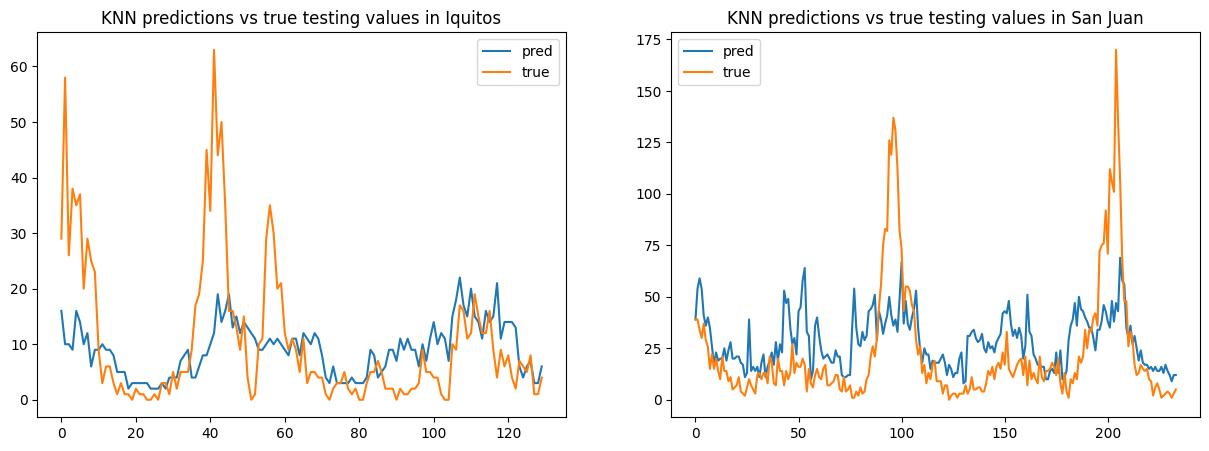

In [190]:
plt.figure(figsize=[15,5])
plt.subplot(121)
# plotting predictions vs testing values for Iquitos
plt.plot(iq_test_pred, label='pred')
plt.plot(iq_y_test.values, label='true')
plt.legend()
plt.title('KNN predictions vs true testing values in Iquitos')
plt.show;
plt.subplot(122)
# plotting predictions vs testing values for San Juan
plt.plot(sj_test_pred, label='pred')
plt.plot(sj_y_test.values, label='true')
plt.legend()
plt.title('KNN predictions vs true testing values in San Juan')
plt.show;

In [191]:
# Get training and testing metrics to check for overfitting
sj_knn_metrics = reg_metrics(sj_y_train, sj_train_pred, sj_y_test, sj_test_pred,'San Juan KNN')
iq_knn_metrics = reg_metrics(iq_y_train, iq_train_pred, iq_y_test, iq_test_pred,'Iquitos KNN')

sj_knn_metrics.T, iq_knn_metrics.T

(San Juan KNN          0
 test_mae      17.572650
 train_mae     24.095442,
 Iquitos KNN         0
 test_mae     7.315385
 train_mae    5.812821)

In [43]:
#concatenating training and testing predictions and values
iq_total_pred = np.hstack((iq_train_pred,iq_test_pred))
iq_true_values = np.hstack((iq_y_train.values,iq_y_test.values))

sj_total_pred = np.hstack((sj_train_pred,sj_test_pred))
sj_true_values = np.hstack((sj_y_train.values,sj_y_test.values))

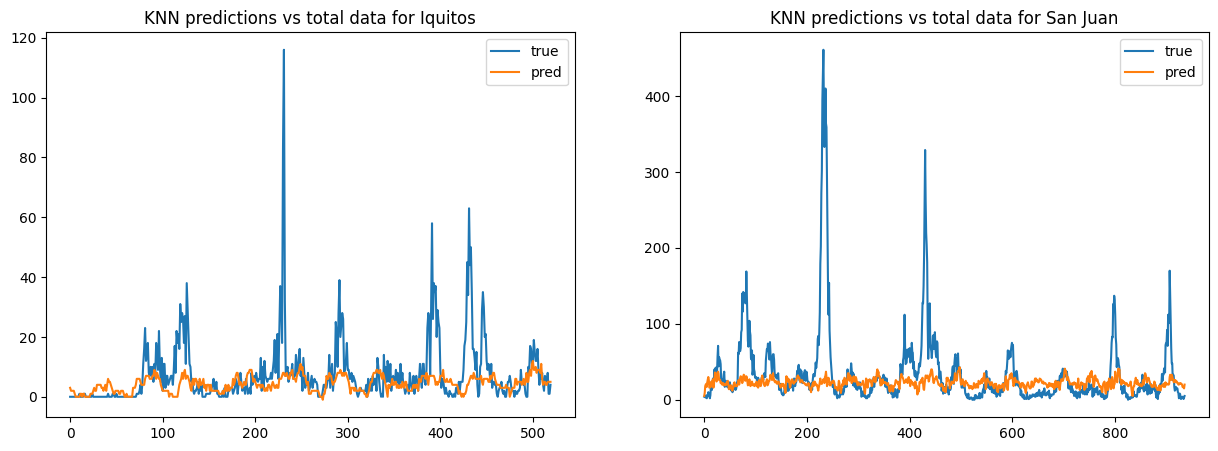

In [192]:
plt.figure(figsize=[15,5])
plt.subplot(121)
plt.plot(iq_true_values, label='true')
plt.plot(iq_total_pred, label='pred')
plt.legend()
plt.title('KNN predictions vs total data for Iquitos')
plt.show;
plt.subplot(122)
plt.plot(sj_true_values, label='true')
plt.plot(sj_total_pred, label='pred')
plt.legend()
plt.title('KNN predictions vs total data for San Juan')
plt.show;

In [82]:
sj_boost = peak_boost(sj_total_pred, 1.5,'pos')
iq_boost = peak_boost(iq_total_pred, 1.5, 'max')

100.64999999999998
26.0


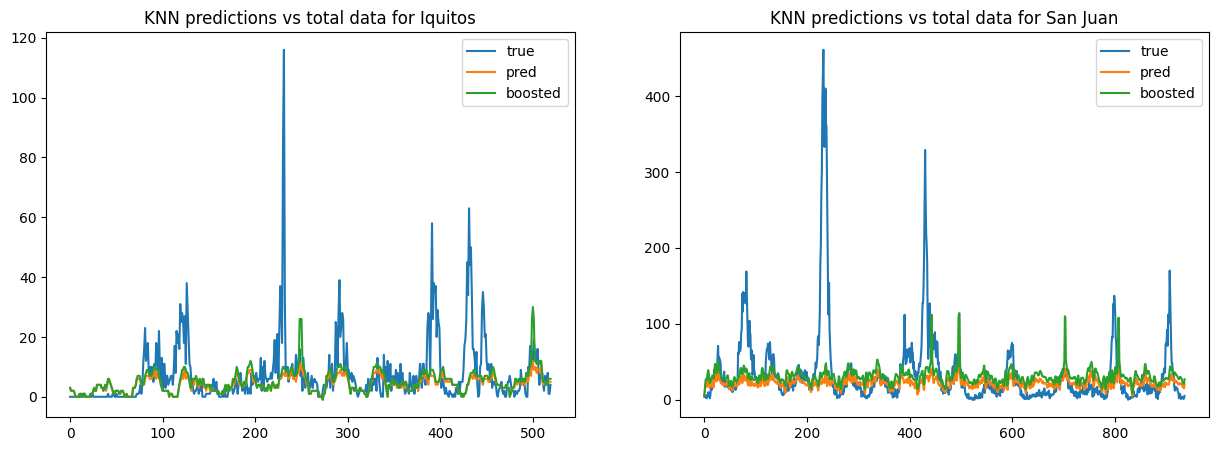

In [193]:
plt.figure(figsize=[15,5])
plt.subplot(121)
plt.plot(iq_true_values, label='true')
plt.plot(iq_total_pred, label='pred')
plt.plot(iq_boost, label='boosted')
plt.legend()
plt.title('KNN predictions vs total data for Iquitos')
plt.show;
plt.subplot(122)
plt.plot(sj_true_values, label='true')
plt.plot(sj_total_pred, label='pred')
plt.plot(sj_boost, label='boosted')
plt.legend()
plt.title('KNN predictions vs total data for San Juan')
plt.show;

In [109]:
sj_train_boost = peak_boost(sj_train_pred, 1.5, 'pos')
sj_test_boost = peak_boost(sj_test_pred, 1.5, 'pos')
iq_train_boost = peak_boost(iq_train_pred, 1.5, 'max')
iq_test_boost = peak_boost(iq_test_pred, 1.5, 'max')

102.99000000000001
73.33999999999997
27.0
19.0


In [187]:
# Get metrics after boosting
sj_knn_metrics = reg_metrics(sj_y_train, sj_train_boost, sj_y_test, sj_test_boost,'San Juan KNN')
iq_knn_metrics = reg_metrics(iq_y_train, iq_train_boost, iq_y_test, iq_test_boost,'Iquitos KNN')

sj_knn_metrics.T, iq_knn_metrics.T

(San Juan KNN          0
 test_mae      15.038462
 train_mae     26.551282,
 Iquitos KNN         0
 test_mae     7.946154
 train_mae    4.682051)

### Support Vector Regressor

In [93]:
#Define the parameters we want to use for the Grid Search
svr_params = {
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'gamma': ['scale','auto'],
    'C':[0.1, 1, 2]
}

In [160]:
#Grid Search SJ
start = time.time()

svr = SVR()
search_svr = GridSearchCV(svr, param_grid=svr_params, 
                              cv=TimeSeriesSplit(n_splits=5), n_jobs=2, verbose=2, scoring='neg_mean_absolute_error')
search_svr.fit(sj_X, sj_y);
sj_svr_params = search_svr.best_params_
print(f'MAE: {abs(search_svr.best_score_)}')

executionTime = (time.time() - start)
print("Execution time:",
      np.round(executionTime,2)," seconds")

Fitting 5 folds for each of 24 candidates, totalling 120 fits
MAE: 24.520754435999713
Execution time: 1.87  seconds


In [161]:
#Grid search param results
sj_svr_params

{'C': 0.1, 'gamma': 'scale', 'kernel': 'poly'}

In [162]:
#Grid Search IQ
start = time.time()

svr = SVR()
search_svr = GridSearchCV(svr, param_grid=svr_params, 
                              cv=TimeSeriesSplit(n_splits=5), n_jobs=2, verbose=2, scoring='neg_mean_absolute_error')
search_svr.fit(iq_X, iq_y);
iq_svr_params = search_svr.best_params_
print(f'MAE: {abs(search_svr.best_score_)}')

executionTime = (time.time() - start)
print("Execution time:",
      np.round(executionTime,2)," seconds")

Fitting 5 folds for each of 24 candidates, totalling 120 fits
MAE: 6.609662649169087
Execution time: 0.87  seconds


In [163]:
#Grid search param results
iq_svr_params

{'C': 0.1, 'gamma': 'scale', 'kernel': 'poly'}

In [164]:
#Initialize models
sj_svr_model = SVR(**sj_svr_params)
iq_svr_model = SVR(**sj_svr_params)

In [165]:
#Fitting models on training data
sj_svr_model.fit(sj_X_train, sj_y_train)
iq_svr_model.fit(iq_X_train, iq_y_train)
print('Training Complete!')

Training Complete!


In [166]:
#Making predictions on training and testing data for San Juan
sj_train_pred = sj_svr_model.predict(sj_X_train).astype(int)
sj_test_pred = sj_svr_model.predict(sj_X_test).astype(int) 

#Making predictions on training and testing data for Iquitos
iq_test_pred = iq_svr_model.predict(iq_X_test).astype(int)
iq_train_pred = iq_svr_model.predict(iq_X_train).astype(int)

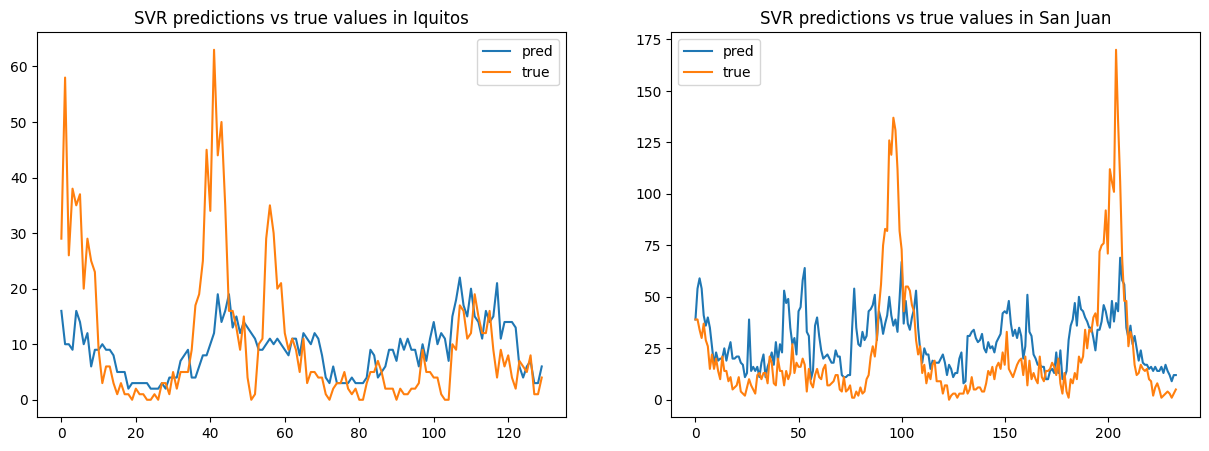

In [194]:
#Plotting predictions vs true values for testing data
plt.figure(figsize=[15,5])
plt.subplot(121)
plt.plot(iq_test_pred, label='pred')
plt.plot(iq_y_test.values, label='true')
plt.legend()
plt.title('SVR predictions vs true values in Iquitos')
plt.show;
plt.subplot(122)
plt.plot(sj_test_pred, label='pred')
plt.plot(sj_y_test.values, label='true')
plt.legend()
plt.title('SVR predictions vs true values in San Juan')
plt.show;

In [168]:
#Get training and testing metrics to check for over/underfitting
sj_svr_metrics = reg_metrics(sj_y_train, sj_train_pred, sj_y_test, sj_test_pred,'San Juan SVR')
iq_svr_metrics = reg_metrics(iq_y_train, iq_train_pred, iq_y_test, iq_test_pred,'Iquitos SVR')

sj_svr_metrics.T, iq_svr_metrics.T

(San Juan SVR          0
 test_mae      17.072650
 train_mae     25.192308,
 Iquitos SVR         0
 test_mae     7.876923
 train_mae    4.633333)

Overfitting  in Iquitos and underfitting in San Juan

In [169]:
#Concatenating training and testing predictions and true values for visualization
iq_total_pred = np.hstack((iq_train_pred,iq_test_pred))
iq_true_values = np.hstack((iq_y_train.values,iq_y_test.values))

sj_total_pred = np.hstack((sj_train_pred,sj_test_pred))
sj_true_values = np.hstack((sj_y_train.values,sj_y_test.values))

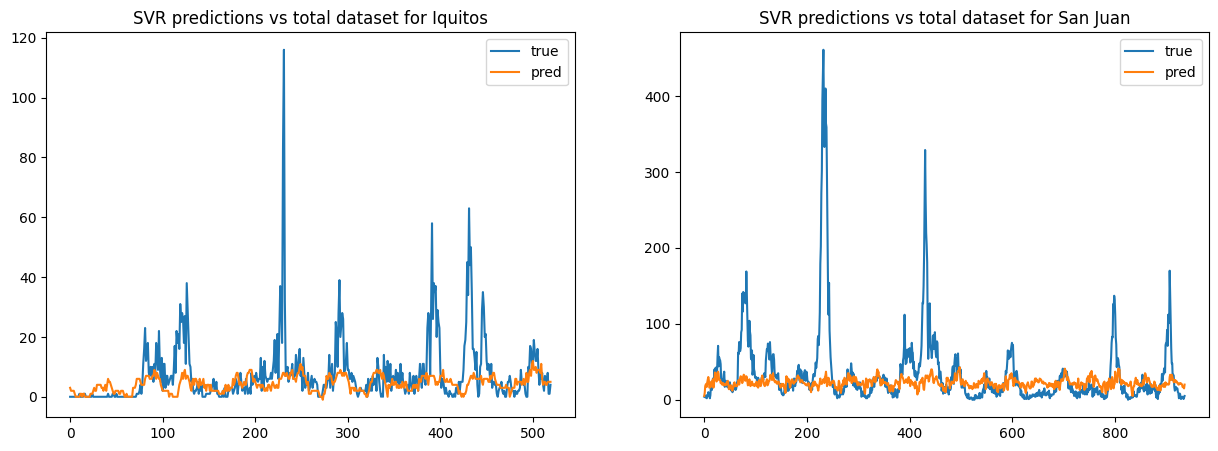

In [195]:
#Plotting predictions vs true values for entire dataset
plt.figure(figsize=[15,5])
plt.subplot(121)
plt.plot(iq_true_values, label='true')
plt.plot(iq_total_pred, label='pred')
plt.legend()
plt.title('SVR predictions vs total dataset for Iquitos')
plt.show;
plt.subplot(122)
plt.plot(sj_true_values, label='true')
plt.plot(sj_total_pred, label='pred')
plt.legend()
plt.title('SVR predictions vs total dataset for San Juan')
plt.show;

In [196]:
#Using the boosting function to boost the peaks of the predictions
sj_boost = peak_boost(sj_total_pred, 1.5,'pos')
iq_boost = peak_boost(iq_total_pred, 1.5, 'max')

53.0
12.809999999999945


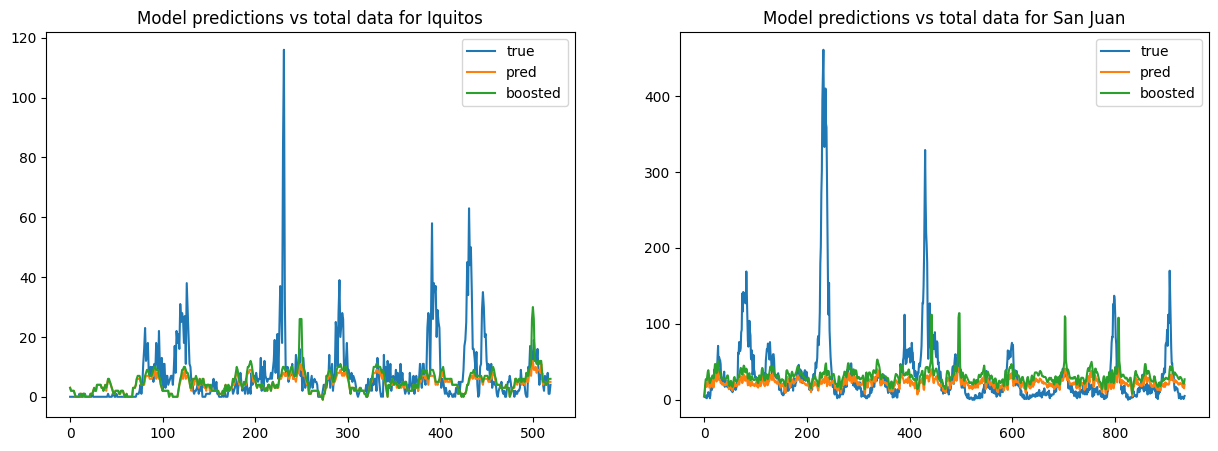

In [197]:
#Plotting boosted predictions vs true values and regular predictions for entire dataset
plt.figure(figsize=[15,5])
plt.subplot(121)
plt.plot(iq_true_values, label='true')
plt.plot(iq_total_pred, label='pred')
plt.plot(iq_boost, label='boosted')
plt.legend()
plt.title('Model predictions vs total data for Iquitos')
plt.show;
plt.subplot(122)
plt.plot(sj_true_values, label='true')
plt.plot(sj_total_pred, label='pred')
plt.plot(sj_boost, label='boosted')
plt.legend()
plt.title('Model predictions vs total data for San Juan')
plt.show;

In [198]:
sj_train_boost = peak_boost(sj_train_pred, 1.5, 'pos')
sj_test_boost = peak_boost(sj_test_pred, 1.5, 'pos')
iq_train_boost = peak_boost(iq_train_pred, 1.5, 'max')
iq_test_boost = peak_boost(iq_test_pred, 1.5, 'max')

99.0
64.66999999999999
28.110000000000014
20.709999999999994


In [199]:
#Get metrics after boosting
sj_svr_metrics = reg_metrics(sj_y_train, sj_train_boost, sj_y_test, sj_test_boost,'San Juan SVR')
iq_svr_metrics = reg_metrics(iq_y_train, iq_train_boost, iq_y_test, iq_test_boost,'Iquitos SVR')

sj_svr_metrics.T, iq_svr_metrics.T

(San Juan SVR          0
 test_mae      15.581197
 train_mae     24.901709,
 Iquitos SVR         0
 test_mae     7.676923
 train_mae    7.243590)

### Random Forest

In [218]:
#Define the parameters we want to use for the Grid Search
rf_params = {
    'max_depth': [None],
    'warm_start': [True, False],
    'max_features': [5,6,7,8,9,10],
    'min_samples_leaf': [4,5,6],
    'min_samples_split': [3],
    'n_estimators': [60,70,80,90],
}

In [219]:
#Grid Search SJ
start = time.time()

rf = RandomForestRegressor(criterion='absolute_error')
search_rf = GridSearchCV(rf, param_grid=rf_params, 
                              cv=TimeSeriesSplit(n_splits=5), n_jobs=2, verbose=2, scoring='neg_mean_absolute_error')
search_rf.fit(sj_X, sj_y);
sj_rf_params = search_rf.best_params_
print(f'MAE: {abs(search_svr.best_score_)}')

executionTime = (time.time() - start)
print("Execution time:",
      np.round(executionTime,2)," seconds")

Fitting 5 folds for each of 144 candidates, totalling 720 fits
MAE: 6.609662649169087
Execution time: 322.89  seconds


In [220]:
sj_rf_params

{'max_depth': None,
 'max_features': 5,
 'min_samples_leaf': 6,
 'min_samples_split': 3,
 'n_estimators': 90,
 'warm_start': False}

In [221]:
#Grid Search IQ
start = time.time()

rf = RandomForestRegressor(criterion='absolute_error')
search_rf = GridSearchCV(rf, param_grid=rf_params, 
                              cv=TimeSeriesSplit(n_splits=5), n_jobs=2, verbose=2, scoring='neg_mean_absolute_error')
search_rf.fit(iq_X, iq_y);
iq_rf_params = search_rf.best_params_
print(f'MAE: {abs(search_svr.best_score_)}')

executionTime = (time.time() - start)
print("Execution time:",
      np.round(executionTime,2)," seconds")

Fitting 5 folds for each of 144 candidates, totalling 720 fits
[CV] END max_depth=None, max_features=5, min_samples_leaf=4, min_samples_split=3, n_estimators=60, warm_start=True; total time=   0.2s
[CV] END max_depth=None, max_features=5, min_samples_leaf=4, min_samples_split=3, n_estimators=60, warm_start=True; total time=   0.5s
[CV] END max_depth=None, max_features=5, min_samples_leaf=4, min_samples_split=3, n_estimators=60, warm_start=True; total time=   1.1s
[CV] END max_depth=None, max_features=5, min_samples_leaf=4, min_samples_split=3, n_estimators=60, warm_start=False; total time=   0.8s
[CV] END max_depth=None, max_features=5, min_samples_leaf=4, min_samples_split=3, n_estimators=70, warm_start=True; total time=   0.2s
[CV] END max_depth=None, max_features=5, min_samples_leaf=4, min_samples_split=3, n_estimators=70, warm_start=True; total time=   0.3s
[CV] END max_depth=None, max_features=5, min_samples_leaf=4, min_samples_split=3, n_estimators=70, warm_start=True; total time

[CV] END max_depth=None, max_features=5, min_samples_leaf=4, min_samples_split=3, n_estimators=60, warm_start=True; total time=   0.3s
[CV] END max_depth=None, max_features=5, min_samples_leaf=4, min_samples_split=3, n_estimators=60, warm_start=True; total time=   0.8s
[CV] END max_depth=None, max_features=5, min_samples_leaf=4, min_samples_split=3, n_estimators=60, warm_start=False; total time=   0.1s
[CV] END max_depth=None, max_features=5, min_samples_leaf=4, min_samples_split=3, n_estimators=60, warm_start=False; total time=   0.3s
[CV] END max_depth=None, max_features=5, min_samples_leaf=4, min_samples_split=3, n_estimators=60, warm_start=False; total time=   0.5s
[CV] END max_depth=None, max_features=5, min_samples_leaf=4, min_samples_split=3, n_estimators=60, warm_start=False; total time=   1.1s
[CV] END max_depth=None, max_features=5, min_samples_leaf=4, min_samples_split=3, n_estimators=70, warm_start=True; total time=   0.9s
[CV] END max_depth=None, max_features=5, min_sample

MAE: 6.609662649169087
Execution time: 123.59  seconds


In [281]:
iq_rf_params = {'max_depth': None,
 'max_features': 10,
 'min_samples_leaf': 4,
 'min_samples_split': 3,
 'n_estimators': 90,
 'warm_start': False}

In [286]:
#Initialize models
sj_rf_model = RandomForestRegressor(**sj_rf_params, criterion='absolute_error')
iq_rf_model = RandomForestRegressor(**iq_rf_params, criterion='absolute_error')

In [225]:
#Fitting models on training data
sj_rf_model.fit(sj_X_train, sj_y_train)
iq_rf_model.fit(iq_X_train, iq_y_train)

print('Training Complete!')

Training Complete!


In [226]:
#Making predictions on training and testing data for San Juan
sj_train_pred = sj_rf_model.predict(sj_X_train).astype(int)
sj_test_pred = sj_rf_model.predict(sj_X_test).astype(int) 

#Making predictions on training and testing data for Iquitos
iq_test_pred = iq_rf_model.predict(iq_X_test).astype(int)
iq_train_pred = iq_rf_model.predict(iq_X_train).astype(int)

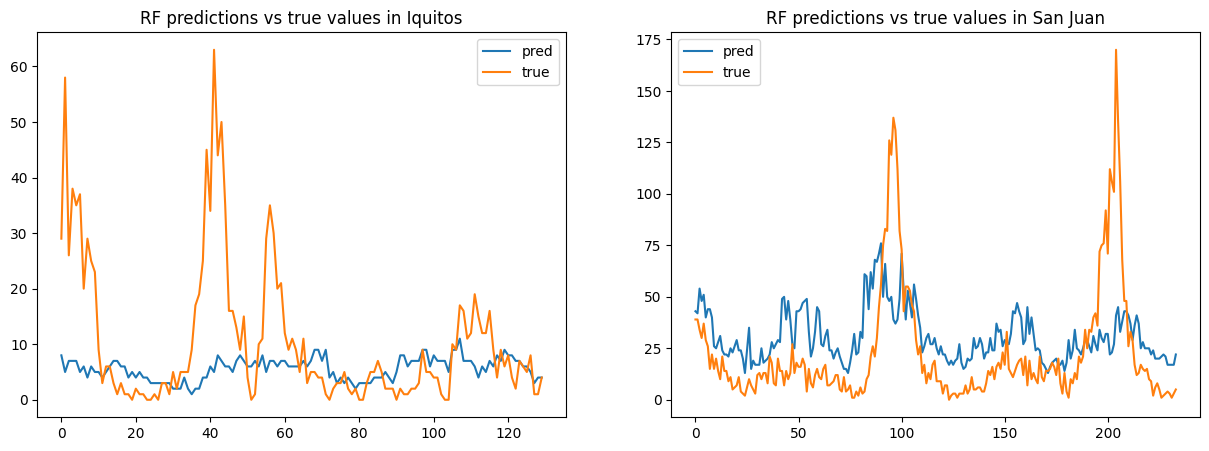

In [228]:
#Plotting predictions vs true values for testing data
plt.figure(figsize=[15,5])
plt.subplot(121)
plt.plot(iq_test_pred, label='pred')
plt.plot(iq_y_test.values, label='true')
plt.legend()
plt.title('RF predictions vs true values in Iquitos')
plt.show;
plt.subplot(122)
plt.plot(sj_test_pred, label='pred')
plt.plot(sj_y_test.values, label='true')
plt.legend()
plt.title('RF predictions vs true values in San Juan')
plt.show;

In [229]:
# Get training and testing metrics to check for overfitting
sj_rf_metrics = reg_metrics(sj_y_train, sj_train_pred, sj_y_test, sj_test_pred,'San Juan rf')
iq_rf_metrics = reg_metrics(iq_y_train, iq_train_pred, iq_y_test, iq_test_pred,'Iquitos rf')

sj_rf_metrics.T, iq_rf_metrics.T

(San Juan rf          0
 test_mae     20.149573
 train_mae    20.259259,
 Iquitos rf         0
 test_mae    7.907692
 train_mae   3.776923)

In [230]:
#concatenating training and testing predictions and values
iq_total_pred = np.hstack((iq_train_pred,iq_test_pred))
iq_true_values = np.hstack((iq_y_train.values,iq_y_test.values))

sj_total_pred = np.hstack((sj_train_pred,sj_test_pred))
sj_true_values = np.hstack((sj_y_train.values,sj_y_test.values))

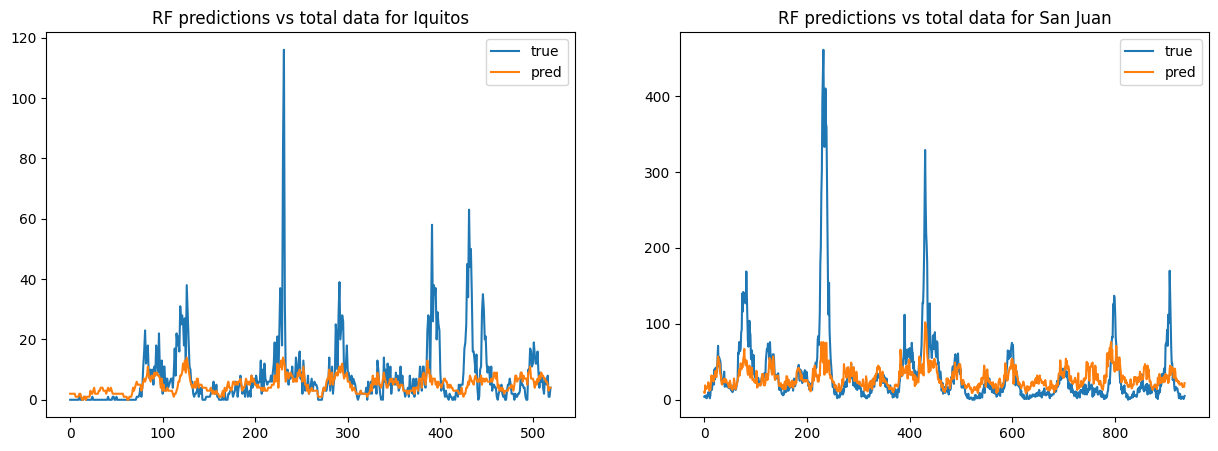

In [232]:
plt.figure(figsize=[15,5])
plt.subplot(121)
plt.plot(iq_true_values, label='true')
plt.plot(iq_total_pred, label='pred')
plt.legend()
plt.title('RF predictions vs total data for Iquitos')
plt.show;
plt.subplot(122)
plt.plot(sj_true_values, label='true')
plt.plot(sj_total_pred, label='pred')
plt.legend()
plt.title('RF predictions vs total data for San Juan')
plt.show;

In [269]:
sj_boost = peakBoost(sj_total_pred, 1.3,'pos')
iq_boost = peakBoost(iq_total_pred, 2.5, 'max')

84.64999999999998
25.809999999999945


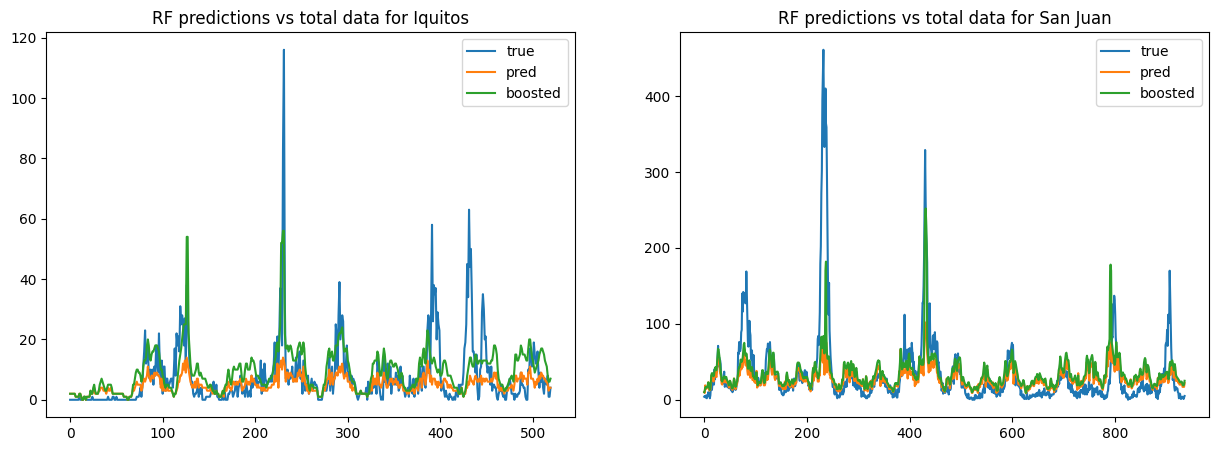

In [270]:
plt.figure(figsize=[15,5])
plt.subplot(121)
plt.plot(iq_true_values, label='true')
plt.plot(iq_total_pred, label='pred')
plt.plot(iq_boost, label='boosted')
plt.legend()
plt.title('RF predictions vs total data for Iquitos')
plt.show;
plt.subplot(122)
plt.plot(sj_true_values, label='true')
plt.plot(sj_total_pred, label='pred')
plt.plot(sj_boost, label='boosted')
plt.legend()
plt.title('RF predictions vs total data for San Juan')
plt.show;

In [259]:
sj_train_boost = peak_boost(sj_train_pred, 1.5, 'pos')
sj_test_boost = peak_boost(sj_test_pred, 1.5, 'pos')
iq_train_boost = peak_boost(iq_train_pred, 1.6, 'max')
iq_test_boost = peak_boost(iq_test_pred, 1.6, 'max')

94.99000000000001
78.01999999999992
17.110000000000014
9.709999999999994


In [260]:
#Get metrics after boosting
sj_rf_metrics = reg_metrics(sj_y_train, sj_train_boost, sj_y_test, sj_test_boost,'San Juan RF')
iq_rf_metrics = reg_metrics(iq_y_train, iq_train_boost, iq_y_test, iq_test_boost,'Iquitos RF')

sj_rf_metrics.T, iq_rf_metrics.T

(San Juan RF          0
 test_mae     17.153846
 train_mae    19.700855,
 Iquitos RF         0
 test_mae    7.976923
 train_mae   3.641026)

### Comparing models

In [262]:
sj_svr_metrics.T, sj_knn_metrics.T, sj_rf_metrics.T, iq_svr_metrics.T, iq_knn_metrics.T, iq_rf_metrics.T

(San Juan SVR          0
 test_mae      15.581197
 train_mae     24.901709,
 San Juan KNN          0
 test_mae      17.572650
 train_mae     24.095442,
 San Juan RF          0
 test_mae     17.153846
 train_mae    19.700855,
 Iquitos SVR         0
 test_mae     7.676923
 train_mae    7.243590,
 Iquitos KNN         0
 test_mae     7.315385
 train_mae    5.812821,
 Iquitos RF         0
 test_mae    7.976923
 train_mae   3.641026)

Although the SVR scored best on the testing data for San Juan and KNN scored best for Iquitos, those models received a submission score of 27.5938, while the two RF models learned the training data best and received a submission score of 24.0024.

## Submission

In [307]:
sj_rf_model.fit(sj_X, sj_y)

iq_rf_model.fit(iq_X, iq_y)

print('Training Complete!')

Training Complete!


In [308]:
testing_data = pd.read_csv('../raw_data/dengue_features_test.csv')

In [309]:
sj_test = testing_data[testing_data.city=='sj'].copy()
sj_test = preprocess(sj_test,train=False)
sj_test.shape

(260, 36)

In [310]:
iq_test = testing_data[testing_data.city=='iq'].copy()
iq_test = preprocess(iq_test,train=False)
iq_test.shape

(156, 36)

In [311]:
sj_pred = sj_rf_model.predict(sj_test).astype(int)
iq_pred = iq_rf_model.predict(iq_test).astype(int)
sj_boost = peak_boost(sj_pred, 2, 'pos')
iq_boost = peak_boost(iq_pred, 2, 'pos')

111.82000000000005
15.449999999999989


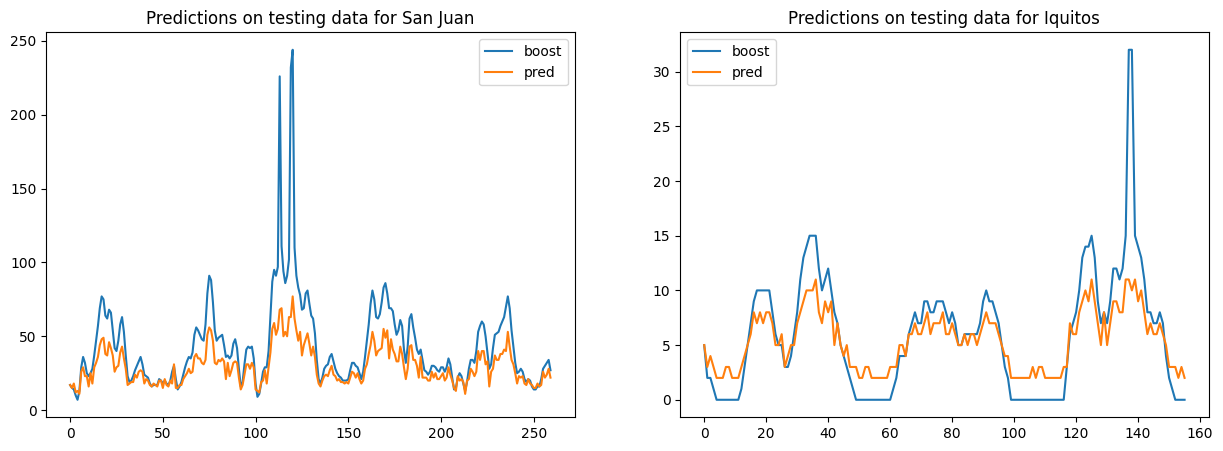

In [312]:
plt.figure(figsize=[15,5])
plt.subplot(121)
plt.plot(sj_boost, label='boost')
plt.plot(sj_pred, label='pred')
plt.legend()
plt.title('Predictions on testing data for San Juan')
plt.show;
plt.subplot(122)
plt.plot(iq_boost, label='boost')
plt.plot(iq_pred, label='pred')
plt.legend()
plt.title('Predictions on testing data for Iquitos')
plt.show;

In [313]:
#Confirm no negative predictions
print(np.min(sj_boost))
print(np.min(iq_boost))

7
0


In [305]:
submission = pd.read_csv('../raw_data/submission_format.csv',
                            index_col=[0, 1, 2])

In [306]:
submission.total_cases = np.concatenate([sj_boost, iq_boost])
submission.to_csv("../submissions/mixed_submission.csv")

KNN: MAE of 27.4351 reached upon submission 

SVR: MAE of 26.5601 reached upon submission

RF: MAE of 24.0024 reached upon submission